<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
from IPython.display import Image
import sys
import numpy as np
sys.path.append('/home/jfiorote/ga_error_sources_framework')
from models.ProteinSystemModel import ProteinSystemModel
from models.GAModel import GAModel
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors

## Initial Values of System

**M**: *int* = Num of sequences;

**n_max**: *int* = Number of pairs in native arrangment, where n in {0, ..., M};

**n_bins**: *int* = Number of intervals in I;

**i_nat**: *float* = Value of i for native arrangment;

**i_0**: *float* = I mean for arrangments with n = 0;

**sigma2_0**: *float* = Variance of I for arrangments with n = 0;

**n_step**: *int* = Max n transition in genetic algorithm.

In [2]:
M = 10             
n_max = M + 1 
n_bins = M + 1 
i_nat = 7
i_0 = 1 
sigma2_0 = 0.02
n_step = 1
minimize = False

## Protein System Model Instance

In [3]:
sys_model = ProteinSystemModel(M, i_0, i_nat, sigma2_0)

## Parametric Equations

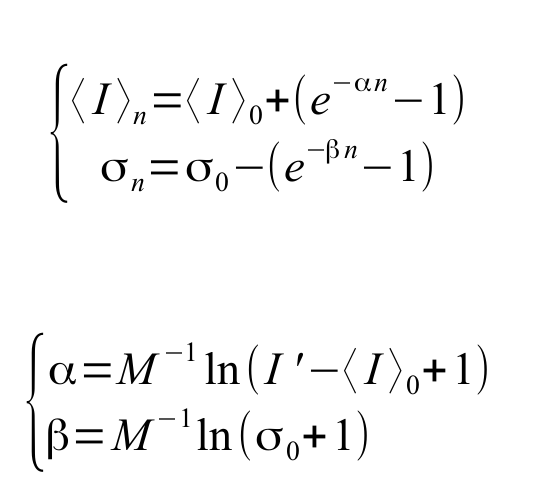

In [4]:
Image('../media/parametric_equations.png', width=300, height=300)

In [5]:
expec_ns = sys_model.expec_ns()
sigma2_ns = sys_model.sigma2_ns()

apha = sys_model.get_alpha()
beta = sys_model.get_beta()

## Generate data

In [6]:
data_s, bins_center = sys_model.create_data()

## Get pdfs and probs of I for each n:

#### function returns a numpy array with size [n_max x n_bins].


-------------------


                bins
         -------------------  <- n=0 
         -------------------
         -------------------
         -------------------
      n  -------------------
         -------------------
         -------------------
         -------------------  <- nmax 
         
         
-------------------


In [7]:
# data fitted in lognorm and probs without poisson weight
pdfs, probs = sys_model.get_prob_bins_lognorm()

# the sum of probs take into consideration the total prob of each n-log-normal
print(f"Sum log-norm prob array = {np.sum(probs)}")

# probs with Poisson weight
w_probs = sys_model.get_probs()

# the prob of log-normal weighted by Poisson is 1
print(f"Sum Poisson * log-norm prob array = {np.sum(w_probs)}")

Sum log-norm prob array = 11.000000000000002
Sum Poisson * log-norm prob array = 0.9999999899522336


## Reassesses probs

In [8]:
# Reassessment doesn't change total probs

r_probs = sys_model.reassessment_probs(probs)
r_w_probs = sys_model.reassessment_probs(w_probs)

print(f"Sum reassessed log-norm prob array = {np.sum(r_probs)}")
print(f"Sum reassessed Poisson * log-norm prob array = {np.sum(r_w_probs)}")

Sum reassessed log-norm prob array = 11.000000000000002
Sum reassessed Poisson * log-norm prob array = 0.9999999899522334


## For plotting:

#### For better representation, flip array: [n_max x n_bins][::-1].


-------------------


                bins
         -------------------  <- nmax  
         -------------------
         -------------------
         -------------------
      n  -------------------
         -------------------
         -------------------
         -------------------  <- n=0 
         
         
-------------------

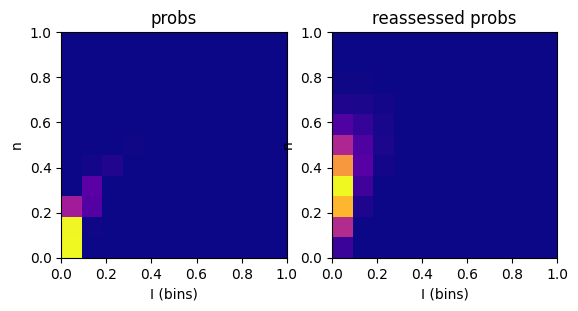

In [14]:
fig, axs = plt.subplots(1, 2)
cmap = "plasma"

z_prob = w_probs[::-1]
rz_prob = r_w_probs[::-1]

c = axs[0].imshow(z_prob, extent=[0, 1, 0, 1], cmap=cmap,  interpolation='nearest')
axs[0].set_title("probs")
axs[0].set_xlabel("I (bins)")
axs[0].set_ylabel("n")

rc = axs[1].imshow(rz_prob, extent=[0, 1, 0, 1], cmap=cmap,  interpolation='nearest')
axs[1].set_title("reassessed probs")
axs[1].set_xlabel("I (bins)")
axs[1].set_ylabel("n")

plt.show()

## GA Model Instance

In [10]:
ga_model = GAModel()

## Get transitions matrix

In [11]:
idx, transitions = ga_model.get_transitions_matrix(probs, n_step=n_step)
ridx, rtransitions = ga_model.get_transitions_matrix_old(probs, n_step=n_step)

np.array_equal(idx, ridx)

True

## Get best path in GA for a system

#### Method returns probs for each step and path.

In [12]:
step_probs, path = ga_model.get_best_path(probs, minimize=False)

## Plot probs and best paths

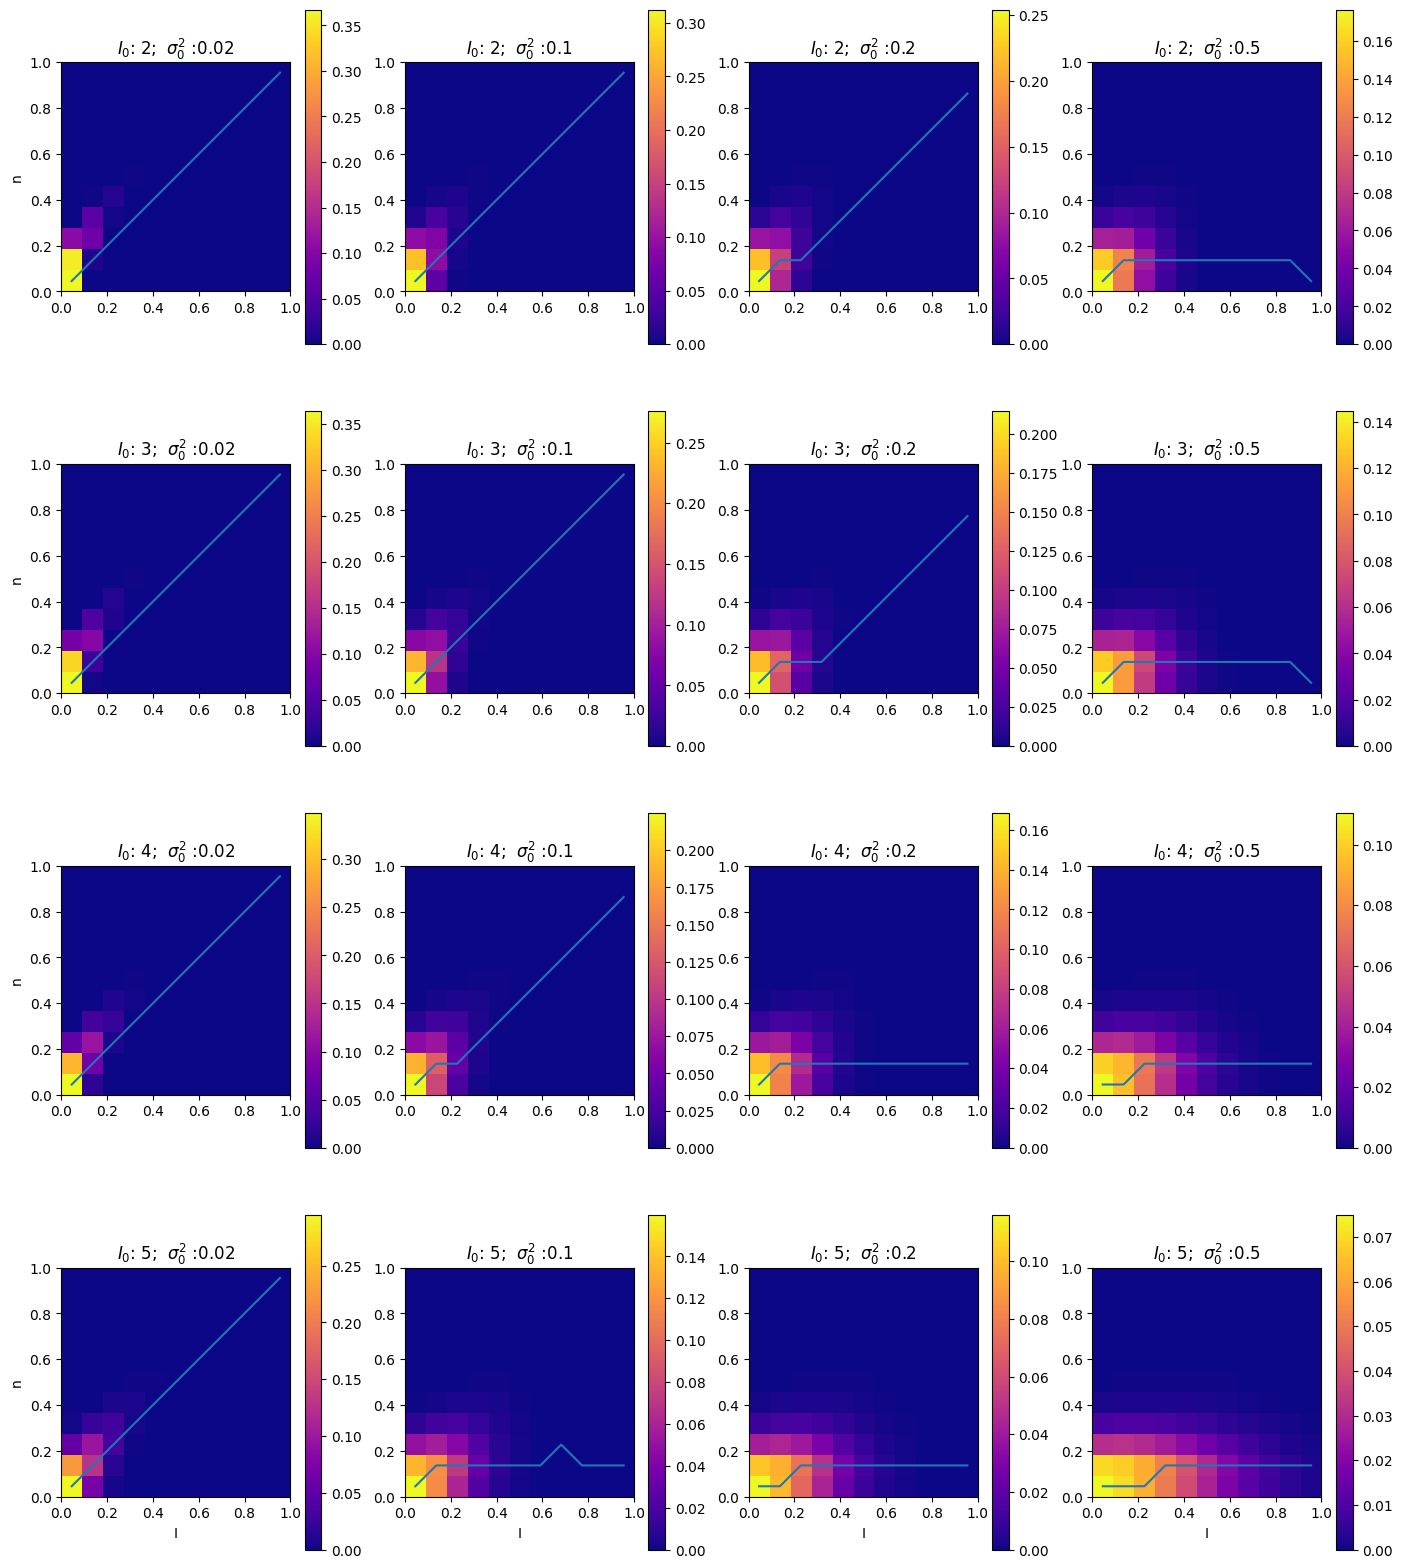

In [13]:
fig, axs = plt.subplots(4, 4, figsize=(17, 20))
cmap = "plasma"

i_0s = [2, 3, 4, 5] 
sigmas2_0 = [0.02, 0.1, 0.2, 0.5]

for idx1, i0 in enumerate(i_0s):
    for idx2, s0 in enumerate(sigmas2_0):

        sys_model = ProteinSystemModel(M, i0, i_nat, s0)
        prob_arr = sys_model.get_probs()
        ga_model = GAModel()
        path = ga_model.get_best_path(prob_arr, minimize=minimize)[0]
        z_prob = np.fliplr(prob_arr[::-1]) if minimize else prob_arr[::-1]
        c = axs[idx1, idx2].imshow(z_prob, extent=[0, 1, 0, 1], 
                                   cmap=cmap,  interpolation='nearest')
        x = [(x[1] / n_bins) + 0.5 * 1 / n_bins for x in path]
        y = [(x[0] / (n_max)) + 0.5 * 1 / (n_max) for x in path]
        ax=axs[idx1, idx2]
        fig.colorbar(c, ax=ax)
        axs[idx1, idx2].plot(x, y)
        axs[idx1, idx2].set_title("".join([r'$I _{0}$', f": {i0};  ", 
                                           r'$\sigma _{0} ^{2}$', f" :{s0}"]))
        
        if idx2 == 0:
            axs[idx1, idx2].set_ylabel("n")
        if idx1 == 3:
            axs[idx1, idx2].set_xlabel("I")
            

plt.show()